In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sklearn

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, kernel_size=1, bias=True)
        self.sigmoid = nn.Sigmoid()

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='linear')
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        avg_out = self.avg_pool(x)        # (B, C, 1, 1)
        avg_out = self.fc1(avg_out)       # (B, C//ratio, 1, 1)
        avg_out = self.relu(avg_out)
        avg_out = self.fc2(avg_out)       # (B, C, 1, 1)

        max_out = self.max_pool(x)        # (B, C, 1, 1)
        max_out = self.fc1(max_out)       # (B, C//ratio, 1, 1)
        max_out = self.relu(max_out)
        max_out = self.fc2(max_out)       # (B, C, 1, 1)

        out = avg_out + max_out           # (B, C, 1, 1)
        scale = self.sigmoid(out)         # (B, C, 1, 1)
        return x * scale                  # broadcast along H, W

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3, 7)
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        # x: (B, C, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)     # (B, 1, H, W)
        max_out, _ = torch.max(x, dim=1, keepdim=True)   # (B, 1, H, W)
        concat = torch.cat([avg_out, max_out], dim=1)    # (B, 2, H, W)
        attn = self.conv(concat)                         # (B, 1, H, W)
        attn = self.sigmoid(attn)
        return x * attn                                  # broadcast across C

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, ratio=8, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, ratio)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, activation, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_ch, in_ch, kernel_size=kernel_size,
            padding=padding, dilation=dilation,
            groups=in_ch, bias=False
        )
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = activation

        nn.init.kaiming_normal_(self.depthwise.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.pointwise.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch, activation):
        super().__init__()
        dilations = [1, 1, 1, 1]
        kernels   = [1, 3, 5, 7]
        self.branches = nn.ModuleList()
        for d, k in zip(dilations, kernels):
            pad = (k // 2) * d
            self.branches.append(
                SepConv(in_ch, out_ch, activation, kernel_size=k, padding=pad, dilation=d)
            )
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations) * out_ch, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            activation
        )
        nn.init.kaiming_normal_(self.merge[0].weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        outs = [branch(x) for branch in self.branches]
        x = torch.cat(outs, dim=1)
        return self.merge(x)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, activation):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            activation,
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            activation
        )
        for m in self.block.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.block(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        # W_g projects gating signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        # W_x projects skip connection
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=False),
            nn.BatchNorm2d(F_int)
        )
        # psi computes 1‐channel attention map
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

        nn.init.kaiming_normal_(self.W_g[0].weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.W_x[0].weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.psi[0].weight, mode='fan_out', nonlinearity='sigmoid')

    def forward(self, g, x):
        """
        g: gating signal from decoder, shape (B, F_g, H, W)
        x: skip connection from encoder, shape (B, F_l, H, W)
        """
        g1 = self.W_g(g)   # (B, F_int, H, W)
        x1 = self.W_x(x)   # (B, F_int, H, W)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)   # (B, 1, H, W)
        return x * psi        # broadcast along channel


class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, activation, dropout_prob=0.0, attention=True, pool=True):
        super().__init__()
        #self.double_conv = DoubleConv(in_ch, out_ch, activation)
        self.aspp        = ASPP(in_ch, out_ch, activation)
        self.cbam        = CBAMBlock(out_ch, ratio=8, kernel_size=7) if attention else nn.Identity()
        self.dropout     = nn.Dropout2d(dropout_prob) if dropout_prob > 0 else nn.Identity()
        self.pool        = pool

    def forward(self, x):
        x = self.aspp(x)
        x = self.cbam(x)
        x = self.dropout(x)
        skip = x.clone()
        if self.pool:
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, activation, dropout_prob=0.0, attention=True, upsample=True):
        """
        in_ch:   channels from previous layer (bottleneck or previous decoder)
        skip_ch: channels in the corresponding encoder skip
        out_ch:  desired output channels for this decoder block
        """
        super().__init__()
        self.upsample = upsample
        self.skip_ch = skip_ch

        if self.upsample:
            # ConvTranspose2d(in_ch → skip_ch) to match spatial & channel dims
            self.up = nn.ConvTranspose2d(in_ch, skip_ch, kernel_size=3,
                                         stride=2, padding=1, output_padding=1, bias=False)
            nn.init.kaiming_normal_(self.up.weight, mode='fan_out', nonlinearity='relu')
            self.bn_up = nn.BatchNorm2d(skip_ch)
            self.act_up = activation
            self.attention = AttentionGate(F_g=skip_ch, F_l=skip_ch, F_int=skip_ch // 2) if attention else nn.Identity()
            in_double = skip_ch * 2
        else:
            self.up = None
            self.bn_up = None
            self.act_up = None
            self.attention = AttentionGate(F_g=in_ch, F_l=in_ch, F_int=in_ch // 2) if attention else nn.Identity()
            in_double = in_ch * 2 if attention else in_ch

        #self.double_conv = DoubleConv(in_double, out_ch, activation)
        self.aspp        = ASPP(in_ch, out_ch, activation)
        self.cbam        = CBAMBlock(out_ch, ratio=8, kernel_size=7) if attention else nn.Identity()
        self.dropout     = nn.Dropout2d(dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x, skip=None):
        if self.upsample:
            x = self.up(x)       # (B, skip_ch, H*2, W*2)
            x = self.bn_up(x)
            x = self.act_up(x)
        if skip is not None and not isinstance(self.attention, nn.Identity):
            skip = self.attention(g=x, x=skip)
            x = torch.cat([x, skip], dim=1)  # (B, 2*skip_ch, H*2, W*2)
        x = self.aspp(x)
        x = self.cbam(x)
        x = self.dropout(x)
        return x


class BottleneckTransformer(nn.Module):
    """
    Takes a tensor of shape (B, C, H, W), flattens the H×W patches into tokens,
    runs a small TransformerEncoder over them, then reshapes back to (B, C, H, W).
    """
    def __init__(self, dim, heads=8, depth=3, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim * 4
        # one TransformerEncoderLayer (or more, if depth>1)
        layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            activation='relu',
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=depth)
        self.norm    = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        # flatten spatial dims:
        # → (B, C, H*W) then permute to (H*W, B, C) for PyTorch’s MHSA
        tokens = x.flatten(2).permute(2, 0, 1)   # (H*W, B, C)
        # run through TransformerEncoder
        out   = self.encoder(tokens)             # (H*W, B, C)
        # put back into (B, C, H, W) after a LayerNorm on each token
        out   = out.permute(1, 2, 0).view(B, C, H, W)
        return self.norm(out.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        # explanation of the two permutes:
        #  - out.permute(1,2,0)→(B, C, H*W) then .view(B, C, H, W)
        #  - we want LN over the C‐dimension, so we permute to (B, H, W, C), apply LayerNorm,
        #    then back to (B, C, H, W).


class UNet(nn.Module):
    def __init__(self,
                 in_channels=1,
                 out_channels=1,
                 down_filters=None,
                 down_activations=None,
                 up_filters=None,
                 up_activations=None):
        super().__init__()
        assert len(down_filters) == len(down_activations)
        assert len(up_filters)   == len(up_activations)

        # Build Encoder path
        self.encoders = nn.ModuleList()
        prev_ch = in_channels
        for i, out_ch in enumerate(down_filters):
            act_str = down_activations[i].lower()
            if act_str == 'relu':
                act_fn = nn.ReLU(inplace=True)
            elif act_str == 'sigmoid':
                act_fn = nn.Sigmoid()
            else:
                raise ValueError(f"Unsupported encoder activation: {act_str}")

            self.encoders.append(
                EncoderBlock(in_ch=prev_ch,
                             out_ch=out_ch,
                             activation=act_fn,
                             dropout_prob=0,
                             attention=(i != 0),
                             pool=True)
            )
            prev_ch = out_ch

        # Bottleneck: DoubleConv(down_filters[-1] → down_filters[-1]*2)
        #self.bottleneck = DoubleConv(down_filters[-1], down_filters[-1]*2, nn.ReLU(inplace=True))
        self.bottleneck_aspp   = ASPP(down_filters[-1], down_filters[-1]*2, nn.ReLU(inplace=True))
        self.bottleneck_trans  = BottleneckTransformer(dim=down_filters[-1]*2,
                                                 heads=8,
                                                 depth=2,
                                                 mlp_dim=down_filters[-1] * 4
                                                 )

        # Build Decoder path
        self.decoders = nn.ModuleList()
        N = len(down_filters)
        for i, out_ch in enumerate(up_filters):
            act_str = up_activations[i].lower()
            if act_str == 'relu':
                act_fn = nn.ReLU(inplace=True)
            elif act_str == 'sigmoid':
                act_fn = nn.Sigmoid()
            else:
                raise ValueError(f"Unsupported decoder activation: {act_str}")
            # Corresponding skip channels from encoder
            skip_ch = down_filters[N - 1 - i]
            # Input channels for this decoder block
            in_ch_dec = (down_filters[-1] * 2) if (i == 0) else up_filters[i - 1]

            self.decoders.append(
                DecoderBlock(in_ch=in_ch_dec,
                             skip_ch=skip_ch,
                             out_ch=out_ch,
                             activation=act_fn,
                             dropout_prob=0,
                             attention=True,
                             upsample=True)
            )

        # Final 3×3 conv + Sigmoid → 1 channel
        self.final_conv = nn.Conv2d(up_filters[-1], out_channels, kernel_size=3, padding=1, bias=False)
        nn.init.kaiming_normal_(self.final_conv.weight, mode='fan_out', nonlinearity='sigmoid')
        self.final_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, 1, 128, 128)
        skips = []
        for enc in self.encoders:
            x, skip = enc(x)
            skips.append(skip)

        #x = self.bottleneck(x)          # (B, 1024, 1, 1)
        x = self.bottleneck_aspp(x)
        x = self.bottleneck_trans(x)
        skips = skips[::-1]              # reverse order for decoding

        for i, dec in enumerate(self.decoders):
            skip_feat = skips[i]
            x = dec(x, skip_feat)

        x = self.final_conv(x)
        x = self.final_sigmoid(x)
        return x  # (B, 1, 32, 32) in your JSON case

In [3]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds:   Tensor (B,1,H,W) after Sigmoid
        targets: Tensor (B,1,H,W) binary {0,1}
        """
        p_flat = preds.view(-1)
        t_flat = targets.view(-1)
        intersection = (p_flat * t_flat).sum()
        dice_coeff = (2. * intersection + self.smooth) / (p_flat.sum() + t_flat.sum() + self.smooth)
        return 1 - dice_coeff

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.gamma, self.eps = alpha, gamma, eps
        self.beta = 1 - alpha  # Ensure alpha + beta = 1

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLossTF(nn.Module):
    def __init__(self, bce_weight=0.33, dice_weight=0.33, focal_twersky_weight=0.33):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss(smooth=1e-6)
        self.FW = FocalTverskyLoss (alpha = 0.99, gamma=3.1)
        self.bw, self.dw, self.fw = bce_weight, dice_weight, focal_twersky_weight

    def forward(self, preds, targets):
        # preds, targets both (B,1,H,W)
        l_bce = self.bce(preds, targets)
        l_dice = self.dice(preds, targets)
        l_focal_tversky = self.FW(preds, targets)
        return self.bw * l_bce + self.dw * l_dice + self.fw * l_focal_tversky

In [4]:
def sigzi(x, axis=None):
    """
Compute the interquartile range (IQR) of x along the specified axis.
    Args:
        x: array-like, shape (P, H, W) or (H, W) or (N, C, H, W)
        axis: axis along which to compute the IQR.
              If None, computes over the flattened array.

    Returns: float, the IQR of x.

    """
    return 0.741 * (np.percentile(x, 75, axis=axis) - np.percentile(x, 25, axis=axis))

def split_stack(arr, nrows, ncols):
    """
    Split a stack of 2D panels into (nrows × ncols) tiles.
    arr: ndarray, shape (P, H, W)
    Returns: ndarray, shape (P * (H//nrows)*(W//ncols), nrows, ncols)
    """
    P, H, W = arr.shape
    pad_h = (-H) % nrows
    pad_w = (-W) % ncols
    if pad_h or pad_w:
        arr = np.pad(arr,
                     ((0, 0),
                      (0, pad_h),
                      (0, pad_w)),
                     mode='constant',
                     constant_values=0)
    H2, W2 = arr.shape[1], arr.shape[2]
    blocks = (arr
              .reshape(P,
                       H2 // nrows, nrows,
                       W2 // ncols, ncols)
              .swapaxes(2, 3))
    P2, Hb, Wb, nr, nc = blocks.shape
    out = blocks.reshape(P2 * Hb * Wb, nr, nc)
    return out

def build_datasets(npz_file, tile_size=128):
    """
    Load data from .npz, clip exactly as TF did, split into tiles, return PyTorch tensors.
      - Clips x to [-166.43, 169.96]
      - Splits each large image into (tile_size × tile_size) patches
      - Adds a channel dimension (→ shape (N, 1, tile_size, tile_size))
    """
    data = np.load(npz_file)
    x = data['x']  # shape (P, H, W)
    y = data['y']

    x = x/sigzi(x)  # normalize by interquartile range
    x = np.clip(x, -5, 5) # clip to [-5, 5]

    # Split into tiles (tile_size × tile_size)
    x_tiles = split_stack(x, tile_size, tile_size)  # (N_tiles, tile_size, tile_size)
    y_tiles = split_stack(y, tile_size, tile_size)

    # Convert to FloatTensor and add channel dimension
    x_tiles = torch.from_numpy(x_tiles).float().unsqueeze(1)  # (N, 1, tile_size, tile_size)
    y_tiles = torch.from_numpy(y_tiles).float().unsqueeze(1)  # (N, 1, tile_size, tile_size)

    return x_tiles, y_tiles

def reshape_masks(masks, new_size):
    """
    Resize binary masks (0/1) to `new_size`:
      - Uses bilinear interpolation (same as TF’s tf.image.resize with bilinear)
      - Applies torch.ceil(...) to recover {0,1} values exactly.
    Input:
      - masks: either a Tensor of shape (N, 1, H_orig, W_orig)
               or a numpy array of shape (N, H_orig, W_orig)
      - new_size: tuple (new_H, new_W)
    Returns:
      - Tensor of shape (N, 1, new_H, new_W), values in {0,1}
    """
    if isinstance(masks, np.ndarray):
        m = torch.from_numpy(masks).float().unsqueeze(1)  # → (N,1,H,W)
    else:
        m = masks  # assume already FloatTensor (N,1,H,W)
    m_resized = F.interpolate(m, size=new_size, mode='bilinear', align_corners=False)
    m_resized = torch.ceil(m_resized)
    return m_resized.clamp(0, 1)

def split_train_val(x_tiles, y_tiles, train_frac=0.8, seed=42):
    """
    Shuffle and split x_tiles, y_tiles into two TensorDatasets: train (80%) and val (20%).
    """
    n = x_tiles.shape[0]
    idx = torch.randperm(n, generator=torch.Generator().manual_seed(seed))
    split = int(train_frac * n)
    train_idx = idx[:split]
    val_idx   = idx[split:]
    x_tr, y_tr = x_tiles[train_idx], y_tiles[train_idx]
    x_val, y_val = x_tiles[val_idx], y_tiles[val_idx]
    return TensorDataset(x_tr, y_tr), TensorDataset(x_val, y_val)

In [5]:
def train_model(model, train_ds, val_ds, epochs=100, batch_size=32, lr=1e-3, device=None):
    """
    Train the model on train_ds, validate on val_ds, and print losses + F1 each epoch.
    Resizes all masks to `output_size` so that preds and targets match in spatial dims.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # 1) Figure out the model’s output spatial size by pushing a dummy 128×128 patch.
    model.eval()  # ensure BatchNorm uses running‐stats, not “batch” stats
    with torch.no_grad():
        dummy = torch.randn(1, 1, 128, 128).to(device)
        out_dummy = model(dummy)
        output_size = (out_dummy.shape[-2], out_dummy.shape[-1])  # e.g. (32,32) for your JSON

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=4, pin_memory=True)

    criterion = ComboLossTF(bce_weight=0.25, dice_weight=0.25, focal_twersky_weight=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=lr,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs,
                                                pct_start=0.1,
                                                anneal_strategy='cos')

    for epoch in range(1, epochs + 1):
        # ——— Training ———
        model.train()
        running_loss = 0.0
        tp = fp = fn = 0
        for batch_num, (imgs, masks) in enumerate(train_loader):
            imgs = imgs.to(device)  # (B,1,128,128)

            # Resize the ground‐truth masks to output_size (e.g. (32,32))
            m_resized = reshape_masks(masks, new_size=output_size).to(device)

            optimizer.zero_grad()
            preds = model(imgs)              # (B,1, output_H, output_W)
            loss = criterion(preds, m_resized)
            loss.backward()

            optimizer.step()
            sched.step()
            optimizer.zero_grad()

            running_loss += loss.item() * imgs.size(0)

            with torch.no_grad():
                pred_bin = (preds > 0.5).float()
                t = m_resized
                tp += (pred_bin * t).sum().item()
                fp += (pred_bin * (1 - t)).sum().item()
                fn += ((1 - pred_bin) * t).sum().item()

            prec = tp / (tp + fp + 1e-8)
            rec  = tp / (tp + fn + 1e-8)
            f1   = 2 * prec * rec / (prec + rec + 1e-8)
            print (f"\rEpoch {epoch:03d}  "
                   f"Batch {batch_num+1:03d}/{len(train_loader)}  "
                   f"Batch Loss: {loss.item():.4f}  "
                   f"| train F1: {f1:.4f}  | train precision: {prec:.4f}  | train recall: {rec:.4f}", end='\r')

        train_loss = running_loss / len(train_ds)
        prec = tp / (tp + fp + 1e-8)
        rec  = tp / (tp + fn + 1e-8)
        f1   = 2 * prec * rec / (prec + rec + 1e-8)

        # ——— Validation ———
        model.eval()
        val_loss = 0.0
        tp = fp = fn = 0
        val_y = []
        pred_val = []
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                m_resized = reshape_masks(masks, new_size=output_size).to(device)
                preds = model(imgs)
                loss = criterion(preds, m_resized)
                val_loss += loss.item() * imgs.size(0)

                pred_bin = (preds > 0.5).float()
                tp += (pred_bin * m_resized).sum().item()
                fp += (pred_bin * (1 - m_resized)).sum().item()
                fn += ((1 - pred_bin) * m_resized).sum().item()
                val_y.append(m_resized.cpu().numpy())
                pred_val.append(preds.cpu().numpy())
        # Collect all validation masks for AUC calculation
        val_y = np.concatenate(val_y, axis=0)
        preds_val = np.concatenate(pred_val, axis=0)  # (N, 1, Hout, Wout)
        val_loss = val_loss / len(val_ds)
        prec = tp / (tp + fp + 1e-8)
        rec  = tp / (tp + fn + 1e-8)
        f1_val = 2 * prec * rec / (prec + rec + 1e-8)
        auc_val = sklearn.metrics.roc_auc_score(val_y.flatten(), preds_val.flatten() )

        print(f"Epoch {epoch:03d}  "
              f"Train Loss: {train_loss:.4f}  "
              f"| Val Loss: {val_loss:.4f}  "
              f"| Train F1: {f1:.4f}  "
              f"| Val F1: {f1_val:.4f}  "
              f"| Val Prec: {prec:.4f}  "
              f"| Val Rec: {rec:.4f}"
              f"| Val AUC: {auc_val:.4f}")

    return model

In [6]:
npz_file = "../DATA/train.npz"
x_tiles, y_tiles = build_datasets(npz_file, tile_size=128)
train_ds, val_ds = split_train_val(x_tiles, y_tiles, train_frac=0.8, seed=42)

In [ ]:
down_filters     = [32, 64, 64, 128, 256, 512]
down_activations = ['relu', 'sigmoid', 'relu', 'relu', 'sigmoid', 'relu']

up_filters       = [512, 256, 128, 64]
up_activations   = ['relu', 'sigmoid', 'relu', 'relu']

model = UNet(
        down_filters=down_filters,
        down_activations=down_activations,
        up_filters=up_filters,
        up_activations=up_activations)


trained_model = train_model(model,
                            train_ds, val_ds,
                            epochs=150,
                            batch_size=128,
                            lr=1e-3)

/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001  Train Loss: 0.6052  | Val Loss: 0.5720  | Train F1: 0.0141  | Val F1: 0.0237  | Val Prec: 0.0124  | Val Rec: 0.2695| Val AUC: 0.6699
Epoch 002  Train Loss: 0.5369  | Val Loss: 0.5290  | Train F1: 0.0263  | Val F1: 0.0243  | Val Prec: 0.0125  | Val Rec: 0.4298| Val AUC: 0.7297


In [8]:
save_path = "../DATA/unet_model1.pth"
torch.save(model.state_dict(), save_path)

In [9]:
model_loaded = UNet(
    down_filters=[32, 32, 64, 128, 256, 512],
    down_activations=['relu', 'relu', 'relu', 'relu', 'sigmoid', 'relu'],
    up_filters=[512, 256, 128, 64],
    up_activations=['relu', 'sigmoid', 'relu', 'sigmoid'],
)

# 2) Load the saved state_dict:
checkpoint = torch.load("../DATA/unet_model1.pth", map_location="cpu")
model_loaded.load_state_dict(checkpoint)

# 3) Put into eval mode (if only doing inference):
model_loaded.eval()


/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


UNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (aspp): ASPP(
        (branches): ModuleList(
          (0): SepConv(
            (depthwise): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (pointwise): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU(inplace=True)
          )
          (1): SepConv(
            (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (pointwise): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU(inplace=True)
          )
          (2): SepConv(
            (depthwise): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
            (pointwise): Conv2d(1, 32, kernel_size=(1, 1), str

In [8]:
def predict(model, dataset, batch_size=32, device=None,
                  return_probs: bool = True,  # if False, returns binary masks (0/1)
                  threshold: float = 0.5      # threshold for binarization if return_probs=False
                 ):
    """
    Run inference on `dataset` using `model` and return all predictions.

    Args:
        model (nn.Module): trained segmentation model (expects input shape (B,1,128,128) → output (B,1,Hout,Wout)).
        dataset (torch.utils.data.Dataset): either
            - A TensorDataset of (images, masks), or
            - A Dataset that returns just `image` (no mask) if you only want predictions.
        batch_size (int): batch size for DataLoader.
        device (torch.device or str): 'cuda' or 'cpu'. If None, uses CUDA if available.
        return_probs (bool):
            - If True, returns the raw sigmoid‐probabilities of shape (N, 1, Hout, Wout).
            - If False, thresholds those probabilities at `threshold` and returns binary masks (0/1).
        threshold (float): cutoff for turning probability → 0/1 when return_probs=False.

    Returns:
        preds: numpy array of shape
            - (N, 1, Hout, Wout) with float32 probs  in [0,1], if return_probs=True;
            - (N, 1, Hout, Wout) with uint8 masks {0,1},       if return_probs=False.

    Usage:
        # 1) If you have (x_val, y_val) as a TensorDataset and want only predictions:
        preds = predict_model(model, TensorDataset(torch.from_numpy(x_val).float(), torch.zeros(len(x_val),1,1,1)),
                              batch_size=64, device='cuda', return_probs=False)

        # 2) If your dataset yields only images (no masks):
        preds = predict_model(model, test_dataset, batch_size=64, device='cuda', return_probs=True)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # We don’t need real masks during inference, so DataLoader can silently ignore them.
    # We'll detect whether dataset returns (img, mask) or just img.
    def _collate_fn(batch):
        # batch is a list of dataset[i] returns.
        # If dataset[i] is a tuple (img, mask), take only img.
        if isinstance(batch[0], (list, tuple)):
            imgs = torch.stack([item[0] for item in batch], dim=0)
        else:
            imgs = torch.stack(batch, dim=0)
        return imgs

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=_collate_fn,
                        num_workers=4, pin_memory=True)

    all_preds = []
    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(device)                     # (B, 1, 128, 128) or similar
            probs = model(imgs)                        # (B, 1, Hout, Wout), already in [0,1] due to final Sigmoid
            if return_probs:
                all_preds.append(probs.cpu())
            else:
                bin_masks = (probs > threshold).float()  # (B, 1, Hout, Wout) of 0.0 or 1.0
                all_preds.append(bin_masks.cpu())

    all_preds = torch.cat(all_preds, dim=0)  # (N, 1, Hout, Wout)
    if return_probs:
        return all_preds.numpy().astype('float32')
    else:
        # convert to uint8 (0/1) for easier downstream use
        return all_preds.numpy().astype('uint8')


In [9]:
def dataset_to_numpy(dataset, batch_size=64, device=None):
    """
    Given a Dataset that returns either:
      - (image_tensor, mask_tensor),  or
      - just image_tensor
    this function will loop once through the dataset, gather everything,
    and return NumPy arrays.

    Returns:
      If dataset[i] returns (img, mask) for each i, then
        imgs_np: shape (N, C, H, W) or whatever
        masks_np: shape (N, Cm, Hm, Wm) (e.g. (N,1,128,128))
      If dataset[i] returns only img, then
        imgs_np: shape (N, C, H, W)
    """

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # We won’t actually move data to GPU here, just stack on CPU at the end.
    # But if your dataset does expensive preprocessing on CPU, you can pin_memory=True.

    def _collate_fn(batch):
        # If each element is (img, mask), we stack only imgs and masks separately.
        # But DataLoader collate_fn must return a single tensor; we’ll handle masks in the loop.
        # Instead, we return the raw batch list and unpack in the loop below.
        return batch

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=_collate_fn,
        num_workers=4,
        pin_memory=True,
    )

    imgs_list = []
    masks_list = []
    with torch.no_grad():
        for batch in loader:
            # batch is a list of length `batch_size` (or the remainder on the last batch).
            # Each element is either (img, mask) or just img.
            first_elem = batch[0]
            if isinstance(first_elem, (tuple, list)) and len(first_elem) == 2:
                # Dataset returns (img, mask)
                imgs = torch.stack([item[0] for item in batch], dim=0)   # (B, C, H, W)
                masks = torch.stack([item[1] for item in batch], dim=0)  # (B, Cm, Hm, Wm)
                imgs_list.append(imgs.cpu().numpy())
                masks_list.append(masks.cpu().numpy())
            else:
                # Dataset returns only img
                imgs = torch.stack(batch, dim=0)  # (B, C, H, W)
                imgs_list.append(imgs.cpu().numpy())

    imgs_np = np.concatenate(imgs_list, axis=0)
    if masks_list:
        masks_np = np.concatenate(masks_list, axis=0)
        return imgs_np, masks_np
    else:
        return imgs_np

def f2_score_numpy(y_true, y_pred, threshold=0.5, eps=1e-8):
    """
    y_true, y_pred: arrays of the same shape, either (N,H,W) or (N,1,H,W).
    threshold: cutoff on y_pred if it’s in [0,1]; if y_pred is already binary, set threshold<0 or skip binarize.
    Returns one global F2 (scalar).
    """
    # 1) Binarize predictions (if they’re probabilities)
    if y_pred.dtype != np.uint8 and threshold >= 0:
        p_bin = (y_pred > threshold).astype(np.uint8)
    else:
        p_bin = y_pred.astype(np.uint8)

    # 2) Similarly ensure y_true is 0/1 uint8
    y_bin = y_true.astype(np.uint8)

    # 3) Flatten to 1D
    if p_bin.ndim == 4 and p_bin.shape[1] == 1:
        p_flat = p_bin.squeeze(1).ravel()
        y_flat = y_bin.squeeze(1).ravel()
    else:
        p_flat = p_bin.ravel()
        y_flat = y_bin.ravel()

    # 4) Compute TP, FP, FN
    TP = np.sum((p_flat == 1) & (y_flat == 1))
    FP = np.sum((p_flat == 1) & (y_flat == 0))
    FN = np.sum((p_flat == 0) & (y_flat == 1))

    # 5) Precision = TP / (TP + FP), Recall = TP / (TP + FN)
    prec = TP / (TP + FP + eps)
    rec  = TP / (TP + FN + eps)

    # 6) F2 = 5 * (prec * rec) / (4*prec + rec)
    f2 = (1 + 2**2) * (prec * rec) / (2**2 * prec + rec + eps)
    return f2

F2 score on validation set: 0.2989


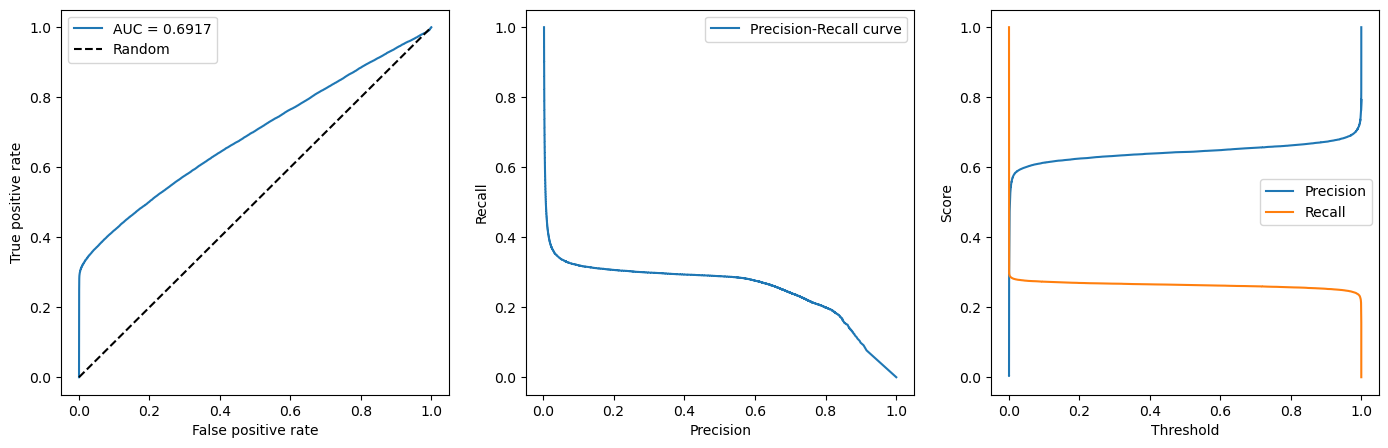

In [11]:
p = predict(model, val_ds, batch_size=128, device='cuda', return_probs=True)
val_x, val_y = dataset_to_numpy(val_ds, batch_size=128)
val_y = reshape_masks(torch.from_numpy(val_y).float(), new_size=(32, 32)).numpy()  # resize to match model output size

fig, ax = plt.subplots(1, 3, figsize=(17, 5))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(val_y.flatten(), p.flatten())
auc_score = sklearn.metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
ax[0].plot([0, 1], [0, 1], 'k--', label='Random')
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].legend()

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(val_y.flatten(), p.flatten())
ax[1].plot(precision, recall, label='Precision-Recall curve')
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].legend()
ax[2].plot(thresholds, precision[1:], label='Precision')
ax[2].plot(thresholds, recall[1:], label='Recall')
ax[2].set_xlabel('Threshold')
ax[2].set_ylabel('Score')
ax[2].legend()
print (f"F2 score on validation set: {f2_score_numpy(val_y, p, threshold=0.5):.4f}")

In [14]:
print (f"F2 score on validation set: {f2_score_numpy(val_y, p, threshold=0.1):.4f}")

F2 score on validation set: 0.3070
